Notebook visualizes a point cloud from a RGBD Image using the open3d library

Step1: Import neccesary libraries

In [1]:
import numpy as np
from src.visualisation.observation_visualisation import display_sample
from src.config import default_sim_cfg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Step2: Read and compute camera intrinsics

In [2]:
#import camera intrinsics
sim_cfg = default_sim_cfg()

#Reading and computing camera intrinsic parameters
w, h = sim_cfg.SENSOR_CFG.WIDTH, sim_cfg.SENSOR_CFG.HEIGHT  # width, height in px
cx, cy = w/2, h/2  # principal point in px
hfov = float(sim_cfg.SENSOR_CFG.HFOV) * np.pi / 180.  # horizontal field of view in rad
f = sim_cfg.SENSOR_CFG.ORTHO_SCALE  # focal length in m

Step 3: Select and display a RGBD image from one of the trajectories

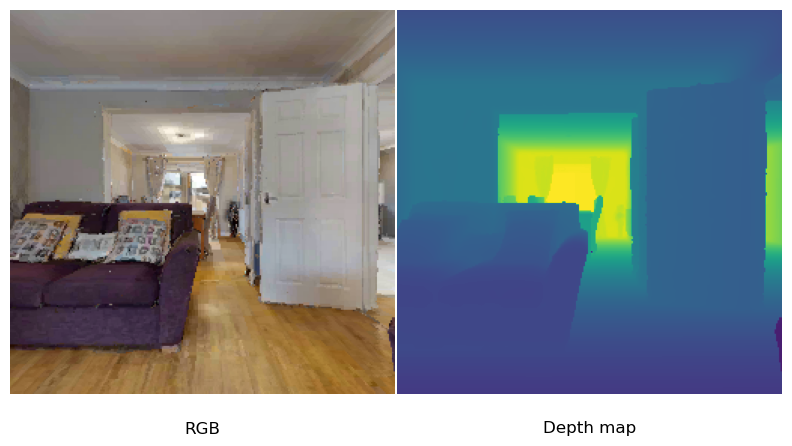

In [3]:
#Select image number 205 from first trajectory to test 3D mapping
#RGB Image
rgb = cv2.imread('/workspaces/ReSEAL/data/interim/trajectories/train/00000-kfPV7w3FaU5/RGB/205.png')
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
#Depth Map
d = np.load('/workspaces/ReSEAL/data/interim/trajectories/train/00000-kfPV7w3FaU5/D/205.npy')

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0)

# Turn off axis labels and ticks for both subplots
for ax in axes:
    ax.set_axis_off()

# Show the images in the subplots
axes[0].imshow(rgb)
axes[0].text(0.5, -0.1, 'RGB', size=12, ha="center", transform=axes[0].transAxes)
axes[1].imshow(d)
axes[1].text(0.5, -0.1, 'Depth map', size=12, ha="center", transform=axes[1].transAxes)
# Show the plot
plt.show()


Step4: Convert that image into a 3D point cloud

In [4]:
# Create RGBDImage object
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(rgb),
    o3d.geometry.Image(d*1000), # in mm
    convert_rgb_to_intensity=False
)

# Create PointCloud object from RGBD image
f = sim_cfg.SENSOR_CFG.ORTHO_SCALE * 1e3  # for `create_from_rgbd_image`, focal length in mm
intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=f, fy=f, cx=cx, cy=cy)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, intrinsic)
pcd = pcd.rotate(pcd.get_rotation_matrix_from_axis_angle([-np.pi/2, 0, 0]))

Step5: Extract 3D coodinates from the point cloud

In [5]:
#Extract the 3D coordinates for each pixel
coordinates = np.asarray(pcd.points)
print(coordinates.shape)
print(coordinates.max())

(57972, 3)
3.786681716442108


Visualize point cloud

In [6]:
# Function for visualizing point cloud in matplotlib

def plot_point_cloud(coordinates, color = None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    cmap = None
    if color is None:
        color = coordinates[:, 2]
        cmap = "viridis"
    ax.scatter(
        coordinates[:, 0],
        coordinates[:, 1],
        coordinates[:, 2],
        c = color,
        cmap = cmap,
        marker=".",
        s=1,
    )
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_box_aspect([1,1,1])

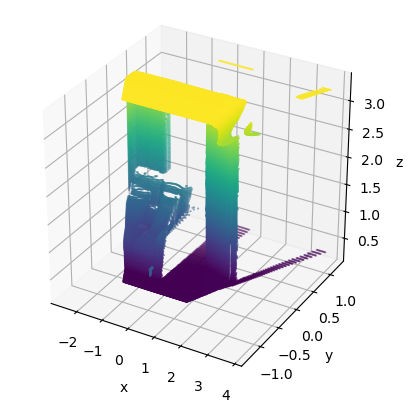

In [7]:
%matplotlib inline
plot_point_cloud(coordinates)

`create_from_depth_image`: focal length is in m

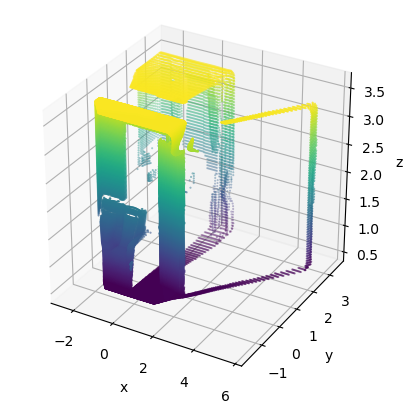

In [8]:
# Create RGBDImage object
d_image = o3d.geometry.Image(d) # in m

# Create PointCloud object from RGBD image
intrinsic = o3d.camera.PinholeCameraIntrinsic(width=w, height=h, fx=f, fy=f, cx=cx, cy=cy)
pcd = o3d.geometry.PointCloud.create_from_depth_image(d_image, intrinsic)
pcd.rotate(pcd.get_rotation_matrix_from_axis_angle([-np.pi/2, 0, 0]))
coordinates = np.asarray(pcd.points)
plot_point_cloud(coordinates)

Visualize point cloud with rgb colour

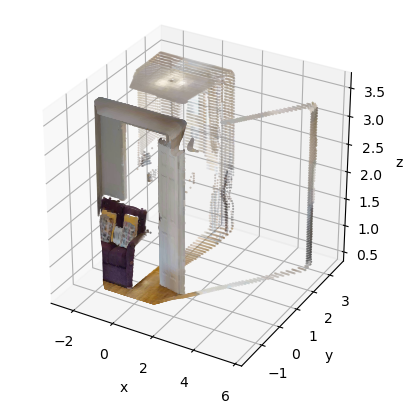

In [9]:
valid_pixels = np.where(d.reshape(-1,1) >0)[0]
pixel_colours = np.reshape(rgb, (-1, 3)) / 256
pixel_colours = pixel_colours[valid_pixels, :]

plot_point_cloud(coordinates, color = pixel_colours)